In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import h5py
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from scipy.ndimage import zoom, rotate
import itertools
from torch.utils.data import Sampler

In [2]:
class params: 
    def __init__(self): 
        self.root_dir = '/kaggle/input/train-dataset/ACDC' 
        self.exp = 'SDCL' 
        self.model = 'unet' 
        self.pretrain_iterations = 800
        
        self.selftrain_iterations = 10 
        self.batch_size = 80
        self.deterministic = 1 
        self.base_lr = 1e-3
        self.img_size = [256,256] 
        self.seed = 42 
        self.num_classes = 4 
        self.patch_size = 16
        self.mask_ratio = 0.5

        # label and unlabel 
        self.labeled_bs = 12
        self.label_num = 7 
        self.u_weight = 0.5 

        # Cost 
        self.gpu = '0' 
        self.consistency = 0.1
        self.consistency_rampup = 200.0 
        self.magnitude = '6.0' 
        self.s_param = 6

        # Caussl parameters 
        self.consistency_type = 'mse'   
        self.max_step = 60 
        self.min_step = 60 
        self.start_step1 = 50 
        self.start_step2 = 50 
        self.cofficient = 3.0 
        self.max_iteration = 5000 
        self.thres_iteration = 20 

args = params() 

In [3]:
class ACDCDataset(Dataset): 
    """
    Use to load ACDC dataset 
    This dataset support 3 modes (strings only): 
    - train_lab: labeled training data 
    - train_unlab: unlabeled traning data 
    - val: validation data 

    Parameters: 
    - base_dir (str): folder save data 
    - split (str): type of data want to load
    - reservse (str): use to reverse the index of data 
    - transform (torchvision.transform): the transform apply for data 
    """
    def __init__(self, base_dir, split='train_lab', reverse=None, transform=None): 
        super(ACDCDataset, self).__init__() 
        self.base_dir = base_dir
        self.split = split
        self.reverse = reverse
        self.transform = transform
        self.sample_list = []

        # Read the file 
        if self.split == 'train_lab': 
            with open(os.path.join(self.base_dir, 'train_lab.list'), 'r') as file: 
                self.sample_list = file.readlines() 
        elif self.split == 'train_unlab': 
            with open(os.path.join(self.base_dir, 'train_unlab.list'), 'r') as file: 
                self.sample_list = file.readlines() 
        elif self.split == 'val': 
            with open(os.path.join(self.base_dir, 'val.list'), 'r') as file: 
                self.sample_list = file.readlines() 
        elif self.split == 'reconstruct': 
            with open(os.path.join(self.base_dir, 'all_slices.list'), 'r') as file: 
                self.sample_list = file.readlines() 
        else: 
            raise ValueError(f'Split: {self.split} is not support for ACDC dataset')
        
        self.sample_list = [item.replace('\n', '') for item in self.sample_list]
        print(f'Mode: {self.split}: {len(self.sample_list)} samples in total')


    def __len__(self): 
        if (self.split == 'train_lab') | (self.split == 'train_unlab'): 
            return len(self.sample_list) * 10 # Why use it ???? 
        
        return len(self.sample_list)

    def __getitem__(self, idx): 
        case = self.sample_list[idx%len(self.sample_list)] # Avoid problem of __len__ 
        if self.reverse: 
            case = self.sample_list[len(self.sample_list) - idx%len(self.sample_list) - 1] 

        # read the file 
        if (self.split == 'train_lab') | (self.split == 'train_unlab') | (self.split == 'reconstruct'): 
            h5f = h5py.File((self.base_dir + f'/data/slices/{case}.h5'), 'r')         
        elif (self.split == 'val'): 
            h5f = h5py.File((self.base_dir + f'/data/{case}.h5'), 'r')
        
        image = h5f['image'][:]
        label = h5f['label'][:]
        sample = {'image': image, 'label': label}

        if self.transform: 
            sample = self.transform(sample)
        image_, label_ = sample['image'], sample['label']
        return image_, label_

In [4]:
def random_rot_flip(image, label): 
    """
    Random rotate and Random flip 
    """
    
    # Random rotate
    k = np.random.randint(0, 4) 
    image = np.rot90(image, k)
    label = np.rot90(label, k)

    # Random flip 
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis).copy() 
    label = np.flip(label, axis).copy() 

    return image, label 

def random_rotate(image, label):
    angle = np.random.randint(-20, 20) 
    image = rotate(image, angle, order= 0, reshape= False)
    label = rotate(label,angle, order=0, reshape= False )
    return image, label


class RandomGenerator: 
    def __init__(self, output_size): 
        self.output_size = output_size
    
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if np.random.random() > 0.5: 
            image, label = random_rot_flip(image, label)
        
        if np.random.random() > 0.5: 
            image, label = random_rotate(image, label) 
        
        # Zoom image to -> [256,256]
        x,y = image.shape
        image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order= 0)
        label = zoom(label, (self.output_size[0] /x , self.output_size[1] / y), order= 0)

        # Convert to pytorch 
        imageTensor = torch.from_numpy(image.astype(np.float32)).unsqueeze(0) # image.shape = (1, H, W)
        labelTensor = torch.from_numpy(label.astype(np.uint8)) # label.shape = (H, W)
        sample = {'image': imageTensor, 'label': labelTensor}
        
        return sample

#### 1. UNet2d

In [5]:
class GRN_ChannelFirst(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.eps = eps

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(2, 3), keepdim=True)   # L2 norm [B, C, 1, 1]
        nx = gx / (gx.mean(dim=1, keepdim=True) + self.eps) # Normalize across channels
        return self.gamma * (x * nx) + self.beta + x # Residual + learnable modulation




# Build again UNet backbone 
class ConvBlock(nn.Module): 
    """
    Two convolution block with batchnorm and leakyrelu 
    Dont change the output size  
    """
    def __init__(self, in_channel, out_channel, dropout_p): 
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel), 
            nn.LeakyReLU(), 
            nn.Dropout(dropout_p)
        )
    
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel), 
            nn.LeakyReLU()
        )
        self.grn = GRN_ChannelFirst(out_channel)  # Add GRN layer

    def forward(self, x): 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.grn(x)
        return x

class DownBlock(nn.Module): 
    """
    Downsample follow by ConvBlock
    """
    def __init__(self, in_channel, out_channel, dropout_p): 
        super(DownBlock, self).__init__() 

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size= 2), 
            ConvBlock(in_channel, out_channel, dropout_p)
        )

    def forward(self, x): 
        return self.maxpool_conv(x)
    

class UpBlock(nn.Module): # Check if have problem  
    def __init__(self, in_channel1, in_channel2, out_channel, dropout_p): 
        super(UpBlock, self).__init__() 

        self.convx1 = nn.Conv2d(in_channel1, in_channel2, kernel_size= 1) # WRD
        self.up = nn.Upsample(scale_factor= 2, mode= 'bilinear', align_corners= True)
        self.conv = ConvBlock(in_channel2 * 2, out_channel, dropout_p)
         
    def forward(self, x1, x2): 
        x1 = self.convx1(x1)
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim= 1)
        return self.conv(x)

class Encoder(nn.Module): 
    def __init__(self, params): 
        super(Encoder, self).__init__()
        self.params = params
        self.in_chs = self.params['in_chs']
        self.ft_chs = self.params['ft_chs']
        self.n_class = self.params['num_class']
        self.dropout = self.params['dropout']
        assert (len(self.ft_chs) == 5)

        self.conv = ConvBlock(self.in_chs, self.ft_chs[0], dropout_p= self.dropout[0])
        self.down1 = DownBlock(self.ft_chs[0], self.ft_chs[1], self.dropout[1])
        self.down2 = DownBlock(self.ft_chs[1], self.ft_chs[2], self.dropout[2])
        self.down3 = DownBlock(self.ft_chs[2], self.ft_chs[3], self.dropout[3])
        self.down4 = DownBlock(self.ft_chs[3], self.ft_chs[4], self.dropout[4])

    def forward(self, x): 
        x0 = self.conv(x) 
        x1 = self.down1(x0) 
        x2 = self.down2(x1) 
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        return [x0, x1, x2, x3, x4]


class Decoder(nn.Module): 
    def __init__(self, params): 
        super(Decoder, self).__init__() 
        self.params = params 
        self.in_chs = self.params['in_chs']
        self.ft_chs = self.params['ft_chs']
        self.n_class = self.params['num_class']
        assert (len(self.ft_chs) == 5)

        self.up1 = UpBlock(self.ft_chs[4], self.ft_chs[3], self.ft_chs[3], dropout_p= 0.0)
        self.up2 = UpBlock(self.ft_chs[3], self.ft_chs[2], self.ft_chs[2], dropout_p= 0.0)
        self.up3 = UpBlock(self.ft_chs[2], self.ft_chs[1], self.ft_chs[1], dropout_p= 0.0)
        self.up4 = UpBlock(self.ft_chs[1], self.ft_chs[0], self.ft_chs[0], dropout_p= 0.0)
        self.out_conv = nn.Conv2d(self.ft_chs[0], self.n_class, kernel_size= 3, padding= 1)


    def forward(self, feature): 
        x0 = feature[0] 
        x1 = feature[1] 
        x2 = feature[2] 
        x3 = feature[3]
        x4 = feature[4] 

        x = self.up1(x4, x3) 
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x_last = self.up4(x, x0)
        output = self.out_conv(x_last)
        return output, x_last
    
class UNet2d(nn.Module): 
    def __init__(self, in_chs, class_num=None, recon=False): 
        super(UNet2d, self).__init__() 
        self.recon = recon
        self.params = {
            'in_chs': in_chs, 
            'ft_chs': [16, 32, 64, 128, 256], 
            'dropout': [0.05, 0.1, 0.2, 0.3, 0.5], 
            'num_class': class_num if not recon else in_chs
        }

        self.encoder = Encoder(self.params) 
        self.decoder = Decoder(self.params)

        # ⬇️ final projection layer for reconstruction
        if recon:
            self.out_conv = nn.Conv2d(self.params['ft_chs'][0], in_chs, kernel_size=3, padding=1)
        else:
            self.out_conv = None

    def forward(self, x): 
        features = self.encoder(x) 
        x_out, x_last = self.decoder(features)

        if self.recon:
            return self.out_conv(x_last)  # Ensure output shape = input shape
        else:
            return x_out
        

#### 2. Patch 

# này dễ tạo shortcut cho model vì các block đều nhau

In [6]:
# def mask_image(img, mask_ratio = 0.5, block_size= 16): 
#     batch_size, channel, H, W = img.shape 
#     assert H % block_size == 0 and W % block_size == 0, 'Block size is not suitable'

#     h_blocks = H // block_size 
#     w_blocks = W // block_size 
#     total_blockes = h_blocks * w_blocks
#     num_mask = int(total_blockes * mask_ratio)

#     mask = torch.ones((batch_size, 1, H, W), device= img.device)

#     for i in range(batch_size): 
#         patch_indices = [(h, w) for h in range(h_blocks) for w in range(w_blocks)]
#         selected = torch.randperm(len(patch_indices))[: num_mask]

#         for idx in selected: 
#             h_idx, w_idx = patch_indices[idx]
#             top = h_idx * block_size 
#             left = w_idx * block_size
#             mask[i, :, top : top + block_size, left : left + block_size] = 0 
    
#     masked_img = img * mask 
#     return masked_img, mask

# random mask FCMAE code

In [7]:
def gen_random_mask(x, patch_size, mask_ratio):
        N = x.shape[0]
        L = (x.shape[2] // patch_size) ** 2
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.randn(N, L, device=x.device)

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # generate the binary mask: 0 is keep 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return mask


def upsample_mask(mask, patch_size, H, W):
    p = int(mask.shape[1] ** 0.5)
    mask = mask.reshape(-1, p, p).unsqueeze(1)  # [B, 1, h, w]
    mask = mask.repeat_interleave(patch_size, 2).repeat_interleave(patch_size, 3)
    return mask  # [B, 1, H, W]

Mode: reconstruct: 1902 samples in total
torch.Size([1, 1, 256, 256])


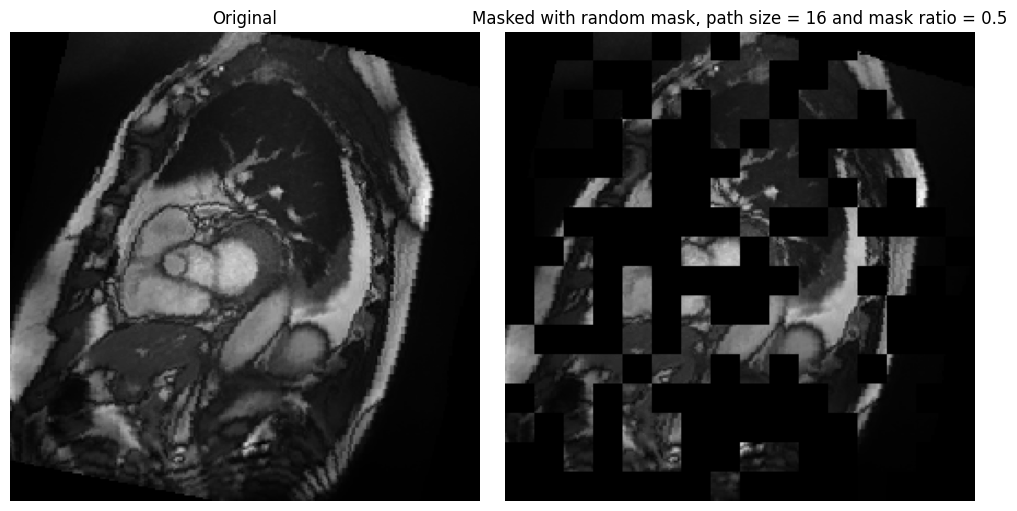

In [8]:
np.random.seed(args.seed)
trainset = ACDCDataset(base_dir= args.root_dir, 
                       split= 'reconstruct', 
                       transform= transforms.Compose([RandomGenerator([256, 256])]))

img, label = trainset[0]
img = img.unsqueeze(0)  # [1, 1, 255, 255]

print(img.shape)


mask = gen_random_mask(img, args.patch_size, mask_ratio=0.5)
mask_up = upsample_mask(mask, args.patch_size, img.shape[2], img.shape[3])
masked_img = img * (1 - mask_up)


plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(img[0, 0].cpu().numpy(), cmap='gray')
plt.title("Original")
plt.axis('off')

# masked image like FCMAE and ViT
plt.subplot(1, 3, 2)
plt.imshow(masked_img[0, 0].cpu().numpy(), cmap='gray')
plt.title(f"Masked with random mask, path size = {args.patch_size} and mask ratio = {args.mask_ratio}")
plt.axis('off')


plt.tight_layout()
plt.show()


#### 3.Training process

In [9]:
def reconstruction_loss(X_rec, X_orig, mask, lam=0.1):
    """
    Compute full L_REC loss as in the SDCL paper:
    mask: 1 for visible, 0 for masked
    lam: lambda weight for visible region
    """
    loss_masked = ((1 - mask) * (X_rec - X_orig) ** 2).sum()
    loss_visible = (mask * (X_rec - X_orig) ** 2).sum()
    
    total_pixels = X_orig.numel()
    loss = (loss_masked + lam * loss_visible) / total_pixels
    return loss


Mode: reconstruct: 1902 samples in total
Epoch 1, Loss: 0.016131
Epoch 2, Loss: 0.008148
Epoch 3, Loss: 0.005622
Epoch 4, Loss: 0.004661
Epoch 5, Loss: 0.004103
Epoch 6, Loss: 0.003574
Epoch 7, Loss: 0.003283
Epoch 8, Loss: 0.003110
Epoch 9, Loss: 0.003118
Epoch 10, Loss: 0.002855
Epoch 11, Loss: 0.002884
Epoch 12, Loss: 0.002648
Epoch 13, Loss: 0.002620
Epoch 14, Loss: 0.002571
Epoch 15, Loss: 0.002364
Epoch 16, Loss: 0.002413
Epoch 17, Loss: 0.002439
Epoch 18, Loss: 0.002276
Epoch 19, Loss: 0.002433
Epoch 20, Loss: 0.002215
Epoch 21, Loss: 0.002247
Epoch 22, Loss: 0.002159
Epoch 23, Loss: 0.002072
Epoch 24, Loss: 0.002181
Epoch 25, Loss: 0.002100
Epoch 26, Loss: 0.001945
Epoch 27, Loss: 0.002100
Epoch 28, Loss: 0.001955
Epoch 29, Loss: 0.001885
Epoch 30, Loss: 0.001965
Epoch 31, Loss: 0.001887
Epoch 32, Loss: 0.001915
Epoch 33, Loss: 0.001841
Epoch 34, Loss: 0.001894
Epoch 35, Loss: 0.001866
Epoch 36, Loss: 0.001850
Epoch 37, Loss: 0.001870
Epoch 38, Loss: 0.001826
Epoch 39, Loss: 0.

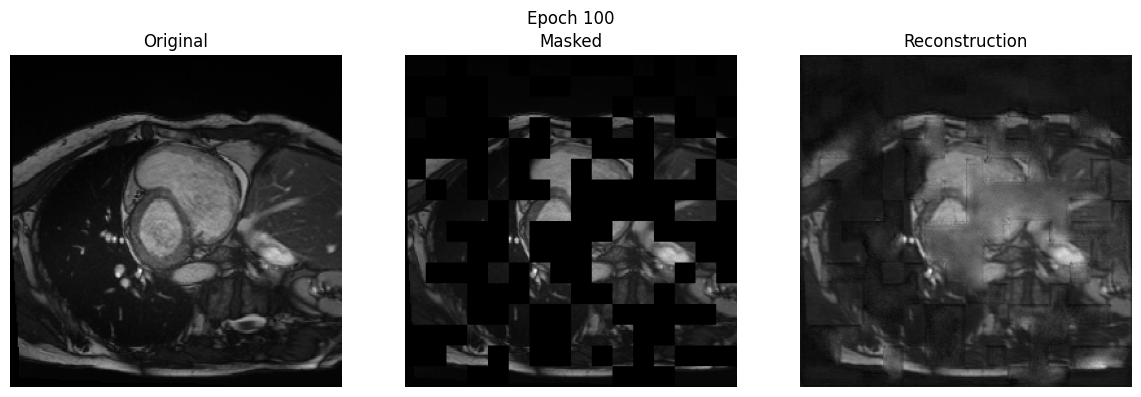

Epoch 101, Loss: 0.001059
Epoch 102, Loss: 0.001090
Epoch 103, Loss: 0.001087
Epoch 104, Loss: 0.001076
Epoch 105, Loss: 0.001043
Epoch 106, Loss: 0.001011
Epoch 107, Loss: 0.001061
Epoch 108, Loss: 0.001039
Epoch 109, Loss: 0.001005
Epoch 110, Loss: 0.001068
Epoch 111, Loss: 0.001030
Epoch 112, Loss: 0.001203
Epoch 113, Loss: 0.001032
Epoch 114, Loss: 0.001054
Epoch 115, Loss: 0.001190
Epoch 116, Loss: 0.001095
Epoch 117, Loss: 0.001058
Epoch 118, Loss: 0.001100
Epoch 119, Loss: 0.000995
Epoch 120, Loss: 0.000966
Epoch 121, Loss: 0.001025
Epoch 122, Loss: 0.001117
Epoch 123, Loss: 0.000979
Epoch 124, Loss: 0.001001
Epoch 125, Loss: 0.001089
Epoch 126, Loss: 0.001011
Epoch 127, Loss: 0.001048
Epoch 128, Loss: 0.001016
Epoch 129, Loss: 0.000978
Epoch 130, Loss: 0.000951
Epoch 131, Loss: 0.000976
Epoch 132, Loss: 0.000933
Epoch 133, Loss: 0.000958
Epoch 134, Loss: 0.000965
Epoch 135, Loss: 0.001055
Epoch 136, Loss: 0.001004
Epoch 137, Loss: 0.000957
Epoch 138, Loss: 0.000924
Epoch 139, L

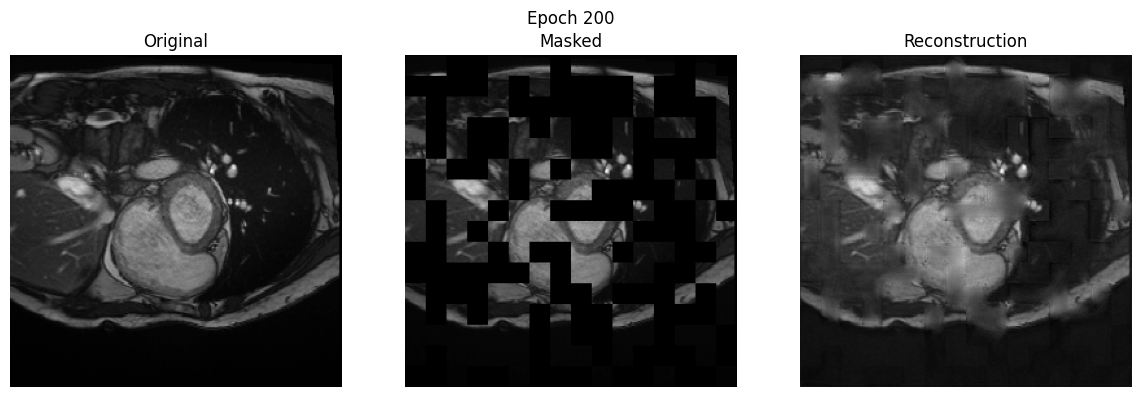

Epoch 201, Loss: 0.000809
Epoch 202, Loss: 0.000770
Epoch 203, Loss: 0.000757
Epoch 204, Loss: 0.000740
Epoch 205, Loss: 0.000801
Epoch 206, Loss: 0.000780
Epoch 207, Loss: 0.000850
Epoch 208, Loss: 0.000757
Epoch 209, Loss: 0.000752
Epoch 210, Loss: 0.000790
Epoch 211, Loss: 0.000732
Epoch 212, Loss: 0.000804
Epoch 213, Loss: 0.000725
Epoch 214, Loss: 0.000823
Epoch 215, Loss: 0.000797
Epoch 216, Loss: 0.000893
Epoch 217, Loss: 0.000723
Epoch 218, Loss: 0.000751
Epoch 219, Loss: 0.000757
Epoch 220, Loss: 0.000761
Epoch 221, Loss: 0.000700
Epoch 222, Loss: 0.000736
Epoch 223, Loss: 0.000768
Epoch 224, Loss: 0.000727
Epoch 225, Loss: 0.000758
Epoch 226, Loss: 0.000715
Epoch 227, Loss: 0.000718
Epoch 228, Loss: 0.000813
Epoch 229, Loss: 0.000705
Epoch 230, Loss: 0.000693
Epoch 231, Loss: 0.000698
Epoch 232, Loss: 0.000723
Epoch 233, Loss: 0.000720
Epoch 234, Loss: 0.000750
Epoch 235, Loss: 0.000731
Epoch 236, Loss: 0.000748
Epoch 237, Loss: 0.000686
Epoch 238, Loss: 0.000756
Epoch 239, L

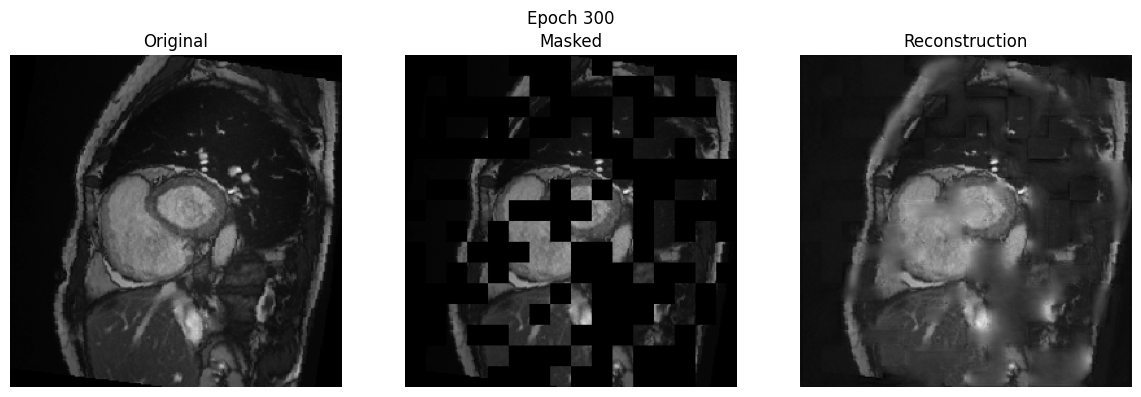

Epoch 301, Loss: 0.000650
Epoch 302, Loss: 0.000619
Epoch 303, Loss: 0.000638
Epoch 304, Loss: 0.000610
Epoch 305, Loss: 0.000619
Epoch 306, Loss: 0.000607
Epoch 307, Loss: 0.000603
Epoch 308, Loss: 0.000631
Epoch 309, Loss: 0.000629
Epoch 310, Loss: 0.000651
Epoch 311, Loss: 0.000716
Epoch 312, Loss: 0.000626
Epoch 313, Loss: 0.000691
Epoch 314, Loss: 0.000648
Epoch 315, Loss: 0.000650
Epoch 316, Loss: 0.000641
Epoch 317, Loss: 0.000819
Epoch 318, Loss: 0.000739
Epoch 319, Loss: 0.000676
Epoch 320, Loss: 0.000630
Epoch 321, Loss: 0.000621
Epoch 322, Loss: 0.000731
Epoch 323, Loss: 0.000652
Epoch 324, Loss: 0.000622
Epoch 325, Loss: 0.000632
Epoch 326, Loss: 0.000742
Epoch 327, Loss: 0.000625
Epoch 328, Loss: 0.000648
Epoch 329, Loss: 0.000638
Epoch 330, Loss: 0.000612
Epoch 331, Loss: 0.000595
Epoch 332, Loss: 0.000609
Epoch 333, Loss: 0.000607
Epoch 334, Loss: 0.000589
Epoch 335, Loss: 0.000651
Epoch 336, Loss: 0.000614
Epoch 337, Loss: 0.000618
Epoch 338, Loss: 0.000634
Epoch 339, L

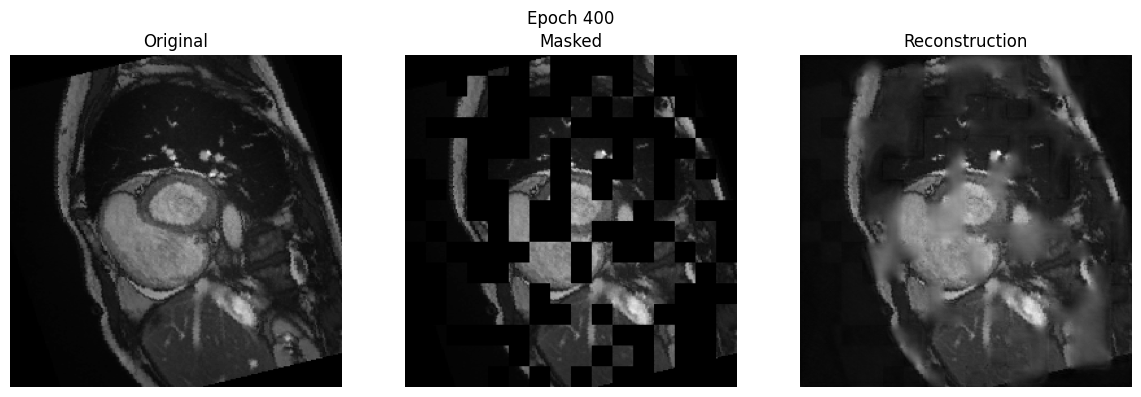

Epoch 401, Loss: 0.000604
Epoch 402, Loss: 0.000734
Epoch 403, Loss: 0.000588
Epoch 404, Loss: 0.000606
Epoch 405, Loss: 0.000549
Epoch 406, Loss: 0.000630
Epoch 407, Loss: 0.000604
Epoch 408, Loss: 0.000658
Epoch 409, Loss: 0.000624
Epoch 410, Loss: 0.000571
Epoch 411, Loss: 0.000545
Epoch 412, Loss: 0.000576
Epoch 413, Loss: 0.000574
Epoch 414, Loss: 0.000576
Epoch 415, Loss: 0.000559
Epoch 416, Loss: 0.000564
Epoch 417, Loss: 0.000551
Epoch 418, Loss: 0.000544
Epoch 419, Loss: 0.000543
Epoch 420, Loss: 0.000568
Epoch 421, Loss: 0.000552
Epoch 422, Loss: 0.000565
Epoch 423, Loss: 0.000535
Epoch 424, Loss: 0.000543
Epoch 425, Loss: 0.000541
Epoch 426, Loss: 0.000531
Epoch 427, Loss: 0.000565
Epoch 428, Loss: 0.000587
Epoch 429, Loss: 0.000564
Epoch 430, Loss: 0.000563
Epoch 431, Loss: 0.000597
Epoch 432, Loss: 0.000562
Epoch 433, Loss: 0.000561
Epoch 434, Loss: 0.000538
Epoch 435, Loss: 0.000542
Epoch 436, Loss: 0.000565
Epoch 437, Loss: 0.000554
Epoch 438, Loss: 0.000550
Epoch 439, L

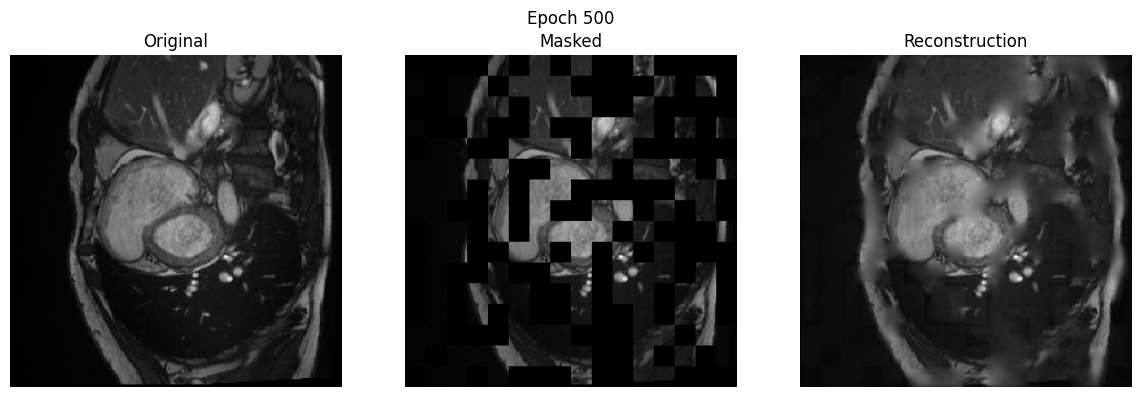

Epoch 501, Loss: 0.000535
Epoch 502, Loss: 0.000525
Epoch 503, Loss: 0.000510
Epoch 504, Loss: 0.000522
Epoch 505, Loss: 0.000523
Epoch 506, Loss: 0.000491
Epoch 507, Loss: 0.000584
Epoch 508, Loss: 0.000541
Epoch 509, Loss: 0.000536
Epoch 510, Loss: 0.000564
Epoch 511, Loss: 0.000527
Epoch 512, Loss: 0.000540
Epoch 513, Loss: 0.000522
Epoch 514, Loss: 0.000497
Epoch 515, Loss: 0.000529
Epoch 516, Loss: 0.000578
Epoch 517, Loss: 0.000516
Epoch 518, Loss: 0.000563
Epoch 519, Loss: 0.000498
Epoch 520, Loss: 0.000551
Epoch 521, Loss: 0.000572
Epoch 522, Loss: 0.000503
Epoch 523, Loss: 0.000599
Epoch 524, Loss: 0.000541
Epoch 525, Loss: 0.000500
Epoch 526, Loss: 0.000540
Epoch 527, Loss: 0.000531
Epoch 528, Loss: 0.000521
Epoch 529, Loss: 0.000514
Epoch 530, Loss: 0.000562
Epoch 531, Loss: 0.000496
Epoch 532, Loss: 0.000494
Epoch 533, Loss: 0.000518
Epoch 534, Loss: 0.000543
Epoch 535, Loss: 0.000523
Epoch 536, Loss: 0.000539
Epoch 537, Loss: 0.000543
Epoch 538, Loss: 0.000571
Epoch 539, L

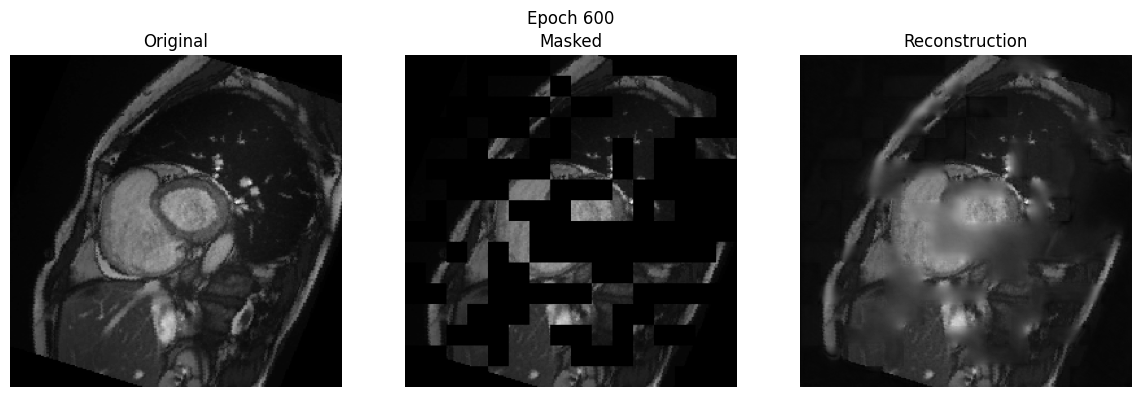

In [10]:
# Prepare data 
trainset = ACDCDataset(base_dir= args.root_dir, 
                       split= 'reconstruct', 
                       transform= transforms.Compose([RandomGenerator(args.img_size)]))
trainloader = DataLoader(trainset, batch_size= args.batch_size, shuffle= False)

model = UNet2d(in_chs=1, recon=True).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 600
mse_loss = nn.MSELoss()

for epoch in range(1, num_epochs + 1):
    for image, _ in trainloader: 
        image = image.cuda() 

        mask = gen_random_mask(image, patch_size=args.patch_size, mask_ratio=args.mask_ratio)
        mask_up = upsample_mask(mask, patch_size=args.patch_size, H= image.shape[2], W =image.shape[3])
        masked_img = image * (1 - mask_up)

        # forward
        masked_img, mask = masked_img.cuda(), mask.cuda() 
        output = model(masked_img)

        # loss (masked + visible)
        loss = reconstruction_loss(output, image, mask_up)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    if epoch % 100 == 0:  
        img_disp = image[0].detach().cpu().squeeze().numpy()
        masked_disp = masked_img[0].detach().cpu().squeeze().numpy()
        recon_disp = output[0].detach().cpu().squeeze().numpy()

        torch.save(model.state_dict(), f"{args.exp}_unet_recon_epoch{epoch}.pth")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.imshow(img_disp, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 3, 2); plt.imshow(masked_disp, cmap='gray'); plt.title('Masked'); plt.axis('off')
        plt.subplot(1, 3, 3); plt.imshow(recon_disp, cmap='gray'); plt.title('Reconstruction'); plt.axis('off')
        plt.suptitle(f"Epoch {epoch}")
        plt.tight_layout()
        plt.show()



# feature cosine distance of each layer 

In [11]:
def compute_cosine_distance(feature: torch.Tensor) -> float:
    """
    Input: [B, C, H, W] → output: scalar cosine distance (normalized to [0,1])
    """
    B, C, H, W = feature.shape
    feature = feature.view(B, C, -1)         # [B, C, HW]
    feature = F.normalize(feature, dim=-1)   # Normalize each vector

    cosine_dists = []
    for b in range(B):
        sim = feature[b] @ feature[b].T      # [C, C] similarity matrix
        sim = sim.clamp(-1 + 1e-6, 1 - 1e-6) # Avoid numerical issues
        dist = (1 - sim) / 2                 # Convert to cosine distance in [0,1]
        avg_dist = dist.sum() / (C * C)
        cosine_dists.append(avg_dist.item())

    return sum(cosine_dists) / len(cosine_dists)

In [12]:
def analyze_encoder_feature_cosine(model, dataloader, device):
    model.eval()
    model.to(device)

    cosine_per_layer = [[] for _ in range(5)]  # x0 to x4

    with torch.no_grad():
        for image, _ in dataloader:
            image = image.to(device)
            features = model.encoder(image)  # returns [x0, x1, ..., x4]

            for i, feat in enumerate(features):
                cosine = compute_cosine_distance(feat)
                cosine_per_layer[i].append(cosine)

    mean_per_layer = [sum(x) / len(x) for x in cosine_per_layer]
    return mean_per_layer


In [13]:
def plot_cosine_distance(mean_per_layer, label='My U-Net + MAE'):
    # norm_layer_idx = [i / (len(mean_per_layer) - 1) for i in range(len(mean_per_layer))]
    layer_names = ['x0', 'x1', 'x2', 'x3', 'x4']
    plt.plot(layer_names, mean_per_layer, marker='o', label=label)
    plt.xlabel("Normalized Layer Index")
    plt.ylabel("Feature Cosine Distance")
    plt.title("Feature Cosine Distance Analysis")
    plt.grid(True)
    plt.legend()
    plt.show()


/tmp/ipykernel_19/78964228.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("SDCL_unet_recon_epoch600.pth"))


Mode: reconstruct: 1902 samples in total


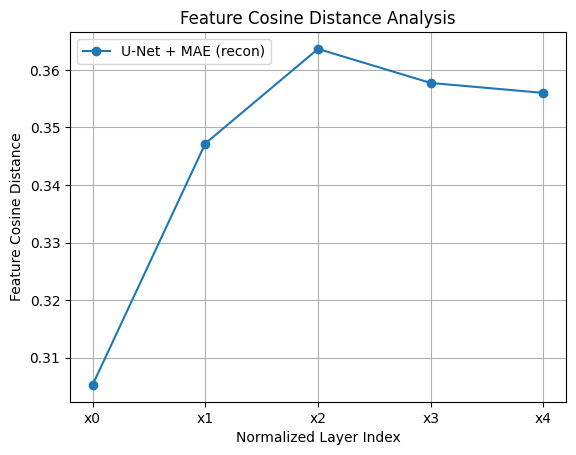

In [14]:
# Load model
model = UNet2d(in_chs=1, recon=True)
model.load_state_dict(torch.load("SDCL_unet_recon_epoch600.pth"))

# Prepare data
dataset = ACDCDataset(base_dir=args.root_dir, split='reconstruct', 
                      transform=transforms.Compose([RandomGenerator(args.img_size)]))
loader = DataLoader(dataset, batch_size=24, shuffle=False)

# Analyze
mean_dist = analyze_encoder_feature_cosine(model, loader, device='cuda')
plot_cosine_distance(mean_dist, label='U-Net + MAE (recon)')


# test variance and entropy of each layer

In [15]:
def analyze_feature_entropy_variance(model, dataloader, device):
    model.eval()
    model.to(device)

    variance_per_layer = [[] for _ in range(5)]
    entropy_per_layer = [[] for _ in range(5)]

    with torch.no_grad():
        for image, _ in dataloader:
            image = image.to(device)
            features = model.encoder(image)  # x0 → x4

            for i, feat in enumerate(features):  # feat: [B, C, H, W]
                B, C, H, W = feat.shape
                feat_flat = feat.view(B, C, -1)  # [B, C, HW]

                # --- Variance ---
                var = feat_flat.var(dim=-1, unbiased=False)  # [B, C]
                mean_var = var.mean().item()
                variance_per_layer[i].append(mean_var)

                # --- Entropy ---
                # Normalize to [0, 1] then compute entropy
                feat_norm = (feat_flat - feat_flat.min()) / (feat_flat.max() - feat_flat.min() + 1e-8)
                hist_bins = 64
                entropy_batch = []

                for b in range(B):
                    entropy_channels = []
                    for c in range(C):
                        hist = torch.histc(feat_norm[b, c], bins=hist_bins, min=0.0, max=1.0)
                        hist = hist / (hist.sum() + 1e-6)  # Normalize to prob
                        entropy = -(hist * (hist + 1e-8).log()).sum()
                        entropy_channels.append(entropy.item())
                    entropy_batch.append(np.mean(entropy_channels))
                entropy_per_layer[i].append(np.mean(entropy_batch))

    # Average over batches
    var_mean = [np.mean(v) for v in variance_per_layer]
    ent_mean = [np.mean(e) for e in entropy_per_layer]
    return var_mean, ent_mean


In [16]:
def plot_entropy_variance(var_mean, ent_mean, label='U-Net'):
    layer_names = ['x0', 'x1', 'x2', 'x3', 'x4']

    plt.figure(figsize=(10, 4))

    # Variance
    plt.subplot(1, 2, 1)
    plt.plot(layer_names, var_mean, marker='o')
    plt.title('Feature Variance per Layer')
    plt.xlabel('Encoder Layer')
    plt.ylabel('Mean Variance')
    plt.grid(True)

    # Entropy
    plt.subplot(1, 2, 2)
    plt.plot(layer_names, ent_mean, marker='o')
    plt.title('Feature Entropy per Layer')
    plt.xlabel('Encoder Layer')
    plt.ylabel('Mean Entropy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


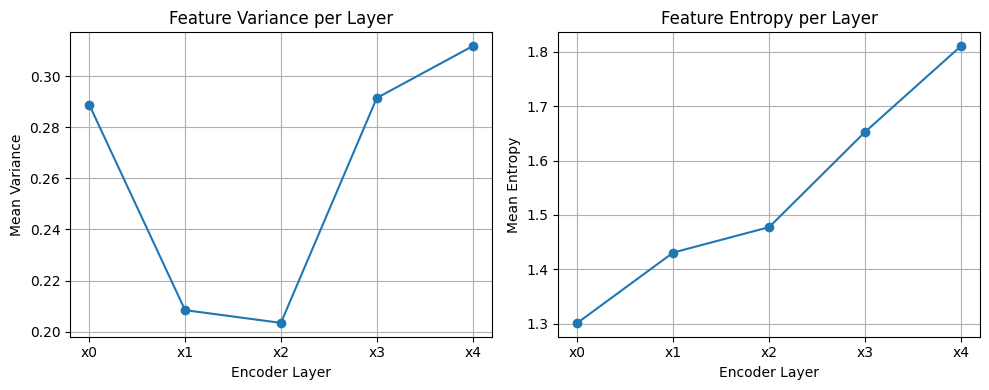

In [17]:
var_mean, ent_mean = analyze_feature_entropy_variance(model, loader, device='cuda')
plot_entropy_variance(var_mean, ent_mean)


# test feature map of 64 first channels

In [18]:
np.random.seed(args.seed)


image, label = dataset[0]
print(image.shape)
image = image.unsqueeze(0).cuda()  
print(image.shape)
features = model.encoder(image)
x0 = features[0]  # features = [x0, x1, x2, x3, x4]
x1 = features[1]  # features = [x0, x1, x2, x3, x4]
x2 = features[2]
x3 = features[3]  # [B, C, H, W]
x4 = features[4]


import matplotlib.pyplot as plt

def visualize_feature_map(feat, title="", grid_size = 8):
    """
    feat: Tensor [B, C, H, W]
    """
    feat = feat.detach().cpu()[0]
    C, H, W = feat.shape

    selected = torch.linspace(0, C - 1, grid_size **2).long()
    images = feat[selected]  #[64, H, W] take first 64 channels 
    
    # normalize to increase contrast
    # images = (images - images.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]) / \
    #          (images.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] + 1e-6)
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for i in range(grid_size**2):
        row, col = divmod(i, grid_size)
        axes[row, col].imshow(images[i], cmap='viridis')
        axes[row, col].axis('off')
    plt.suptitle(title)
    plt.tight_layout()



torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])


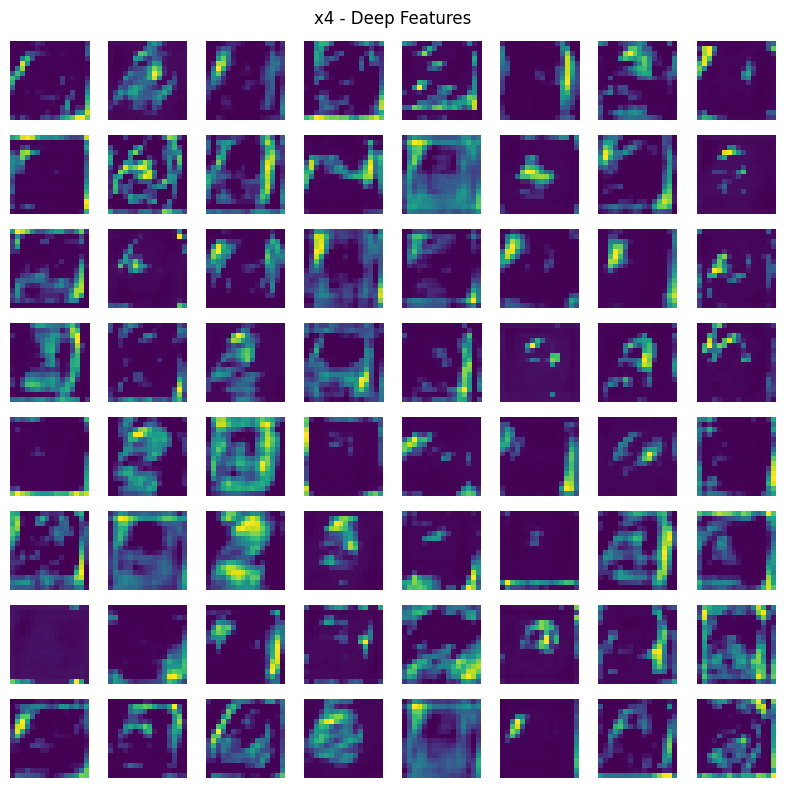

In [19]:
model.eval()
with torch.no_grad():
    image, _ = next(iter(loader))  # first batch
    image = image.to('cuda')
    features = model.encoder(image)

visualize_feature_map(x4, title='x4 - Deep Features')
